# Sentimental Analysis of Product based reviews 

###         Importing the required packages

In [1]:
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np    # linear algebra

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

#%config InlineBackend.figure_format = "retina"

import time

from sklearn.model_selection import  train_test_split 

from sklearn.metrics import roc_curve, auc

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB , BernoulliNB

from sklearn.ensemble import RandomForestClassifier 

import os

In [2]:
# ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(os.getcwd(),"\n")

C:\Users\Rithish Miryala\Downloads\mini proj build 



In [4]:
# Input data files are available in the read-only "dataset/" directory
# For example, running below cell will list all files under the dataset directory

In [5]:
# collecting all the datasets and concatenating them to a single dataframe
datasets=[]
for dirname, _, filenames in os.walk('dataset/'):
    for filename in filenames:
        filepath=os.path.join(dirname, filename)
        print(filepath)
        datasets.append(filepath)

# creating a empty dataframe
amazon_data=pd.DataFrame()

# adding all the datasets to the amazon_data dataframe
for i in datasets:
    amazon_data=pd.concat([amazon_data,pd.read_csv(i)])

print("\nShape of dataset : ",amazon_data.shape)

dataset/Amazon_Unlocked_Mobile.csv

Shape of dataset :  (413840, 6)


In [6]:
print(amazon_data.info())
print("\n\nNull values in each row  :\n\n",amazon_data.isna().sum())
print("\nTotal null values in dataset  :  ",amazon_data.isna().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB
None


Null values in each row  :

 Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

Total null values in dataset  :   83462


In [7]:
# Removinging all the rows with null values
print("Shape of dataset before dropping null  :  ",amazon_data.shape )
amazon_data=amazon_data.dropna(axis =0)

print("\nShape of dataset after dropping null   :  ",amazon_data.shape ,"\n")
print(amazon_data.head())
print(amazon_data.tail())

Shape of dataset before dropping null  :   (413840, 6)

Shape of dataset after dropping null   :   (334335, 6) 

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. Th

In [8]:
print("Rating values in dataset are : ", sorted(amazon_data.Rating.unique()))

Rating values in dataset are :  [1, 2, 3, 4, 5]


In [9]:
print("Features are \n",amazon_data.columns)

Features are 
 Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')


In [10]:
# here the target variable is Rating
# we are dealing with reviews whether they are positive or negative or neutral
# and also ratings to compare with predicted rating value and get the accuracy score
# so we consider only reviews and rating to be features for the dataframe
amazon_data=amazon_data[["Reviews","Rating"]] 
amazon_data.head()

,Reviews,Rating
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4


In [11]:
# spliting dataframe as positive and negative dataframes 
# considering 4,5 rating as positive review 1,2 as negative review

Value Count graph for each rating


<AxesSubplot:>

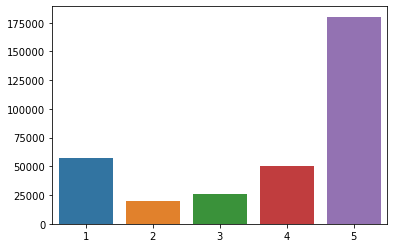

In [12]:
print("Value Count graph for each rating")
sns.barplot(x=amazon_data.Rating.value_counts().index,y=amazon_data.Rating.value_counts().values)

In [13]:
amazon_data_pos =amazon_data[amazon_data["Rating"].isin([4,5])]
print (amazon_data_pos.head())
print(amazon_data_pos.tail())

                                             Reviews  Rating
0  I feel so LUCKY to have found this used (phone...       5
1  nice phone, nice up grade from my pantach revu...       4
2                                       Very pleased       5
3  It works good but it goes slow sometimes but i...       4
4  Great phone to replace my lost phone. The only...       4
                                                  Reviews  Rating
413830                                            LOVE IT       5
413832  good rugged phone that has a long-lasting batt...       4
413835                     another great deal great price       5
413837        Passes every drop test onto porcelain tile!       5
413839  Only downside is that apparently Verizon no lo...       4


In [14]:
amazon_data_neg=amazon_data[amazon_data["Rating"].isin([1,2])] 
print(amazon_data_neg.head())
print(amazon_data_neg.tail())

                                              Reviews  Rating
5   I already had a phone with problems... I know ...       1
6   The charging port was loose. I got that solder...       2
7   Phone looks good but wouldn't stay charged, ha...       2
13  I'm really disappointed about my phone and ser...       1
15  Had this phone before and loved it but was not...       2
                                                  Reviews  Rating
413817  This is the second junk Convoy I have owned. T...       1
413820  They said phone was normal wear but it was a l...       1
413828                                     Would not work       1
413831  Item was listed as new, but was not. When we t...       1
413834                                          used hard       1


In [15]:
print("Shape of complete dataframe : ",amazon_data.shape)
print("Shape of positive dataframe : ",amazon_data_pos.shape)
print("Shape of negative dataframe : ",amazon_data_neg.shape)

Shape of complete dataframe :  (334335, 2)
Shape of positive dataframe :  (230674, 2)
Shape of negative dataframe :  (77603, 2)


In [16]:
# considering equal rows from negative and positive dataframe each 
# to get equal amount of model training for positive and negative reviews

minimumcount=min(20000,amazon_data_pos.shape[0],amazon_data_neg.shape[0])


print(amazon_data_pos.shape)
print(amazon_data_neg.shape)
amazon_data_pos=amazon_data_pos[:minimumcount]
amazon_data_neg=amazon_data_neg[:minimumcount]
print(amazon_data_pos.shape)
print(amazon_data_neg.shape)

(230674, 2)
(77603, 2)
(20000, 2)
(20000, 2)


<AxesSubplot:>

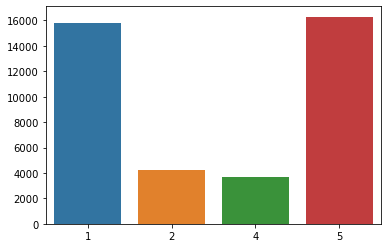

In [17]:
# add an extra feature as r to consider 4,5 rating as 1 and 1,2 rating as 0 
# here 0,1 indicates the rating as negative and posite respectively
amazon_data_pos['r']=1
amazon_data_neg['r']=0
# merging two dataframes to single dataframe as filtered dataframe
amazon_data_filtered =pd.concat([amazon_data_pos,amazon_data_neg])
sns.barplot(x=amazon_data_filtered.Rating.value_counts().index,y=amazon_data_filtered.Rating.value_counts().values)

In [18]:
print(amazon_data_filtered.head())
print(amazon_data_filtered.tail())

print("\n",amazon_data_filtered.r.value_counts())

                                             Reviews  Rating  r
0  I feel so LUCKY to have found this used (phone...       5  1
1  nice phone, nice up grade from my pantach revu...       4  1
2                                       Very pleased       5  1
3  It works good but it goes slow sometimes but i...       4  1
4  Great phone to replace my lost phone. The only...       4  1
                                                  Reviews  Rating  r
109307  Phone does not work, no one can hear me talkin...       1  0
109308  A little disappointing, doesn't have any memor...       2  0
109310                      poor volume very hard to hear       1  0
109313  I received the phone with damaged screen , I r...       1  0
109316  It was slow not what i expected small screen o...       1  0

 1    20000
0    20000
Name: r, dtype: int64


In [19]:
amazon_data_filtered["Reviews"]
from sklearn.model_selection import train_test_split
X_train_data, x_test_data,Y_train_data,y_test_data=train_test_split(amazon_data_filtered["Reviews"],amazon_data_filtered["r"],test_size=0.2,shuffle=True)

print("total shape of dataframe : ",amazon_data_filtered.shape)
print("obtained rows of Y after split (train , test)  : (",Y_train_data.shape[0],",", y_test_data.shape[0],")")
print("obtained rows of X after split (train , test)  : (",X_train_data.shape[0],",", x_test_data.shape[0],")")
print("sum =", sum((Y_train_data.shape[0],y_test_data.shape[0])))
print()
print(Y_train_data.head(), y_test_data.head(),"\n", sep="\n\n")
print(Y_train_data.tail(), y_test_data.tail(),"\n", sep="\n\n")
print(X_train_data.head(), x_test_data.head(),"\n", sep="\n\n")
print(X_train_data.tail(), x_test_data.tail(),"\n", sep="\n\n")

total shape of dataframe :  (40000, 3)
obtained rows of Y after split (train , test)  : ( 32000 , 8000 )
obtained rows of X after split (train , test)  : ( 32000 , 8000 )
sum = 40000

87091    0
8776     0
84710    0
2094     1
19833    1
Name: r, dtype: int64

95062    0
509      0
31410    1
31961    1
20994    1
Name: r, dtype: int64



30056    1
29083    0
10860    1
37771    0
47271    0
Name: r, dtype: int64

89744    0
34068    1
4951     1
93632    0
12932    1
Name: r, dtype: int64



87091                                      Go with defects
8776     love the phone but was a little disappointed w...
84710    I am an American consumer and was excited to r...
2094     Beautiful phone at an incredible price point. ...
19833    Excellent! The phone is in great condition. Ex...
Name: Reviews, dtype: object

95062    unfortunately the blackberry doesn't work, has...
509      It was advertised as being unlocked and compat...
31410                           Good purchase - works wel

In [20]:
#tfidf Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vector=TfidfVectorizer(stop_words= "english")

tfidf_vector.fit(X_train_data)
print(tfidf_vector.get_feature_names()[:20])

print(tfidf_vector.get_feature_names()[-28])


['00', '000', '0000', '000mah', '002', '00emotional', '00now', '00pm', '00so', '00time', '01', '013435003182980', '014', '018633051660f', '02', '03', '04', '04th', '06', '07']
zenphone


In [21]:
X_train_data_new=tfidf_vector.transform(X_train_data)

print(X_train_data_new.shape)

x_test_data_new=tfidf_vector.transform(x_test_data)

(32000, 15528)


In [22]:
print(X_train_data_new,Y_train_data)
# xczx

  (0, 4043)	1.0
  (1, 15305)	0.20356276229346879
  (1, 15044)	0.38431596683369434
  (1, 12945)	0.2929933534139658
  (1, 11997)	0.23675684234386077
  (1, 10157)	0.09184593890134056
  (1, 8379)	0.20588446890753603
  (1, 8233)	0.26365773572987583
  (1, 8059)	0.3297246345330459
  (1, 6144)	0.3420575756298256
  (1, 6122)	0.3219632069485964
  (1, 4478)	0.2530981626381678
  (1, 940)	0.39393442733452577
  (2, 14828)	0.09018424744375411
  (2, 14647)	0.05724721600378502
  (2, 14625)	0.11286291478118275
  (2, 13456)	0.10208222181390401
  (2, 13300)	0.12981007293151456
  (2, 12934)	0.35852850348559906
  (2, 12189)	0.1316395249006128
  (2, 11823)	0.11891154816144159
  (2, 11561)	0.08476676893703763
  (2, 11452)	0.12110911423838903
  (2, 11178)	0.06304733160227488
  (2, 10320)	0.20564667371322604
  :	:
  (31996, 1102)	0.23757298054193002
  (31997, 5388)	1.0
  (31998, 15295)	0.18667534676976927
  (31998, 12581)	0.1693413265852145
  (31998, 12399)	0.3078903725681622
  (31998, 12092)	0.2879678906457484

In [23]:
# function to calculate time taken 
def calcTime(startTime):
    endTime=time.time()
    Time=(endTime-startTime)
    return str(round(Time/60.0,4))+" min  or  "+str(round(Time,4))+" sec"

def modelAnalyzer(classifierName):
    print("\n\n",classifierName," Classifier",sep="") 
    print("Accuracy                :::", accuracy[classifierName])
    #Generating Confusion matrix
    print("Confusion matrix        :::")
    print(confusion_matrix(y_test_data, predictions[classifierName]))

    #Calculating Precision, Recall and Measure
    print("\nclassification report   :::")
    print(classification_report(y_test_data, predictions[classifierName], target_names=["Positive", "Negative"]))

    #Generating ROC curve
    false_positive, true_positive,_= roc_curve(y_test_data,predictions[classifierName])
    plt.title("Receiver perating characteristic")
    plt.plot(false_positive, true_positive)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


predictions=dict()
accuracy=dict()




SVM classifier
Please be patient. This may take some time.
Train Started
Time taken to fit       ::: 2.6623 min  or  159.7409 sec
Time taken to predict   ::: 0.1597 min  or  9.5828 sec
Accuracy                ::: 0.971625


SVM Classifier
Accuracy                ::: 0.971625
Confusion matrix        :::
[[3928  117]
 [ 110 3845]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.97      0.97      0.97      4045
    Negative       0.97      0.97      0.97      3955

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



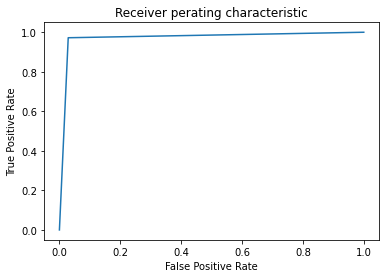

Overall time taken for SVM classifier ::: 2.8253 min  or  169.5196 sec


In [24]:
#1. SVM classifier
print("\n\nSVM classifier") 
print("Please be patient. This may take some time.")
svm_model=SVC()

#Train Model
print("Train Started")
aaa=time.time()
svm_model.fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions['SVM']=svm_model.predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

# Calculating model accuracy
accuracy['SVM']=accuracy_score(y_test_data, predictions['SVM'])
print("Accuracy                :::", accuracy['SVM'])

modelAnalyzer('SVM')
print("Overall time taken for SVM classifier :::",calcTime(aaa))



Multinomial Naive Bayes Classifier
Please be patient. This may take some time.
Train Started
Time taken to fit       ::: 0.0002 min  or  0.012 sec
Time taken to predict   ::: 0.0 min  or  0.002 sec
Accuracy                ::: 0.939


Multinomial Naive Bayes Classifier
Accuracy                ::: 0.939
Confusion matrix        :::
[[3826  219]
 [ 269 3686]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94      4045
    Negative       0.94      0.93      0.94      3955

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000



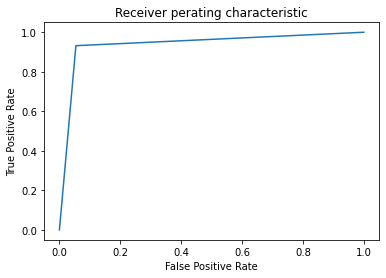

Overall time taken for Multinomial Naive Bayes Classifier::: 0.0038 min  or  0.225 sec


In [25]:
#2. Multinomial Naive Bayes Classifier

print("\n\nMultinomial Naive Bayes Classifier") 
print("Please be patient. This may take some time.")

mul_model=MultinomialNB()

#Train Model
print("Train Started")
aaa=time.time()
mul_model.fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["Multinomial Naive Bayes"]=mul_model.predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Multinomial Naive Bayes"]=accuracy_score(y_test_data, predictions["Multinomial Naive Bayes"])
print("Accuracy                :::", accuracy["Multinomial Naive Bayes"])

modelAnalyzer("Multinomial Naive Bayes")

print("Overall time taken for Multinomial Naive Bayes Classifier:::",calcTime(aaa))



Bernoulli Naive Bayes Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0003 min  or  0.016 sec
Time taken to predict   ::: 0.0001 min  or  0.004 sec
Accuracy                ::: 0.821375


Bernoulli Naive Bayes Classifier
Accuracy                ::: 0.821375
Confusion matrix        :::
[[2799 1246]
 [ 183 3772]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.94      0.69      0.80      4045
    Negative       0.75      0.95      0.84      3955

    accuracy                           0.82      8000
   macro avg       0.85      0.82      0.82      8000
weighted avg       0.85      0.82      0.82      8000



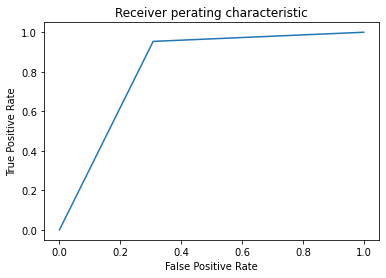

Overall time taken for Bernoulli Naive Bayes Classifier ::: 0.0036 min  or  0.217 sec


In [26]:
#3. Bernoulli Naive Bayes Classifier

print("\n\nBernoulli Naive Bayes Classifier") 
print("Please be patient. This may take some time")

ber_model=BernoulliNB()

#Train Model
print("Train Started")
aaa=time.time()
ber_model.fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["Bernoulli Naive Bayes"]=ber_model.predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Bernoulli Naive Bayes"]=accuracy_score(y_test_data, predictions["Bernoulli Naive Bayes"])
print("Accuracy                :::", accuracy["Bernoulli Naive Bayes"])

modelAnalyzer("Bernoulli Naive Bayes")

print("Overall time taken for Bernoulli Naive Bayes Classifier :::",calcTime(aaa))



RandomForest Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.4622 min  or  27.7299 sec
Time taken to predict   ::: 0.0058 min  or  0.349 sec
Accuracy                ::: 0.96825


RandomForest Classifier
Accuracy                ::: 0.96825
Confusion matrix        :::
[[3935  110]
 [ 144 3811]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.96      0.97      0.97      4045
    Negative       0.97      0.96      0.97      3955

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



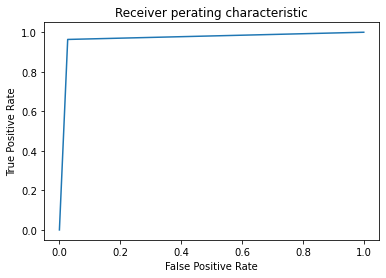

Overall time taken for RandomForest Classifier ::: 0.4711 min  or  28.269 sec


In [27]:
#4. RandomForest Classifier

print("\n\nRandomForest Classifier") 
print("Please be patient. This may take some time")

rfc_model=RandomForestClassifier()

#Train Model
print("Train Started")
aaa=time.time()
rfc_model.fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["RandomForest"]=rfc_model.predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["RandomForest"]=accuracy_score(y_test_data, predictions["RandomForest"])
print("Accuracy                :::", accuracy["RandomForest"])

modelAnalyzer("RandomForest")

print("Overall time taken for RandomForest Classifier :::",calcTime(aaa))



Calculating Accuracy of each model


                     Model  Accuracy
0                      SVM  0.971625
1  Multinomial Naive Bayes  0.939000
2    Bernoulli Naive Bayes  0.821375
3             RandomForest  0.968250


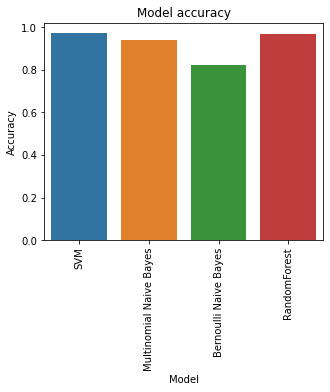

In [28]:
#GUI Code

def compare_models():
    print("\n\nCalculating Accuracy of each model\n\n")
    
    #Model Accuracy Table    
    result_table=pd.DataFrame(list(accuracy.items()), columns=["Model", "Accuracy"]) 
    print (result_table)

    #Bar chart comparing accuracies of models 
    plt.figure(figsize =(5,4))   #

    sns.barplot(x="Model", y="Accuracy", data =result_table) 
    plt.title("Model accuracy")

    plt.xticks (rotation = 90)  #
compare_models()

In [29]:
def analyze_each():
    def get_Details(choice): 
        print("Details are")
        modelAnalyzer(list(accuracy.keys())[choice-1])
    print("Classifier Model") 
    i=1
    for classifier in accuracy.keys():
        print(i,": ",classifier,sep="")
        i+=1
    print("Enter your choice")
    choice=int(input())
    get_Details(choice)
    
analyze_each()

Classifier Model
1: SVM
2: Multinomial Naive Bayes
3: Bernoulli Naive Bayes
4: RandomForest
Enter your choice
a


ValueError: invalid literal for int() with base 10: 'a'

In [ ]:
accuracy.keys()

In [31]:
def predict_rating(): 
    print("Customer Review  :::")
    
    Inp_text=input()

    review=Inp_text
    new_test_transform = tfidf_vector.transform([review])
    
    Out_text="Positive" if rfc_model.predict(new_test_transform) else "Negative"
    
    
    print ("Rating  :::", Out_text)

predict_rating()

Customer Review  :::
21qw
Rating  ::: Positive


In [ ]:
def actions(choice):
    if choice==1: 
        analyze_each()
    elif choice==2:
        predict_rating() 
    else:
        compare_models() 
            
print("Sentiment Analysis of Customer Reviews") 
while(True):
    print("1: Analyze the model")
    print("2: Predict the Rating")
    print("3: Compare the Models")
    print("4: Quit")
    choice=int(input())
    if(choice == 4):
        break
    actions(choice)


Sentiment Analysis of Customer Reviews
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
2
Customer Review  :::
working
Rating  ::: Positive
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
2
Customer Review  :::
sadsad
Rating  ::: Positive
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
2
Customer Review  :::
sad
Rating  ::: Negative
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
2
Customer Review  :::
im sad
Rating  ::: Negative
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit


## MODEL SAVE 

In [ ]:
import pickle 
file=open("svm_model.pkl","wb")
pickle.dump(svm_model,file)

In [ ]:
file